Import the Libraries

In [2]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.model_selection import train_test_split

In [3]:
from google.colab import files
drive.mount('/content/drive')

Mounted at /content/drive


Import the CSV Files

In [4]:
train_csv = r'/content/drive/MyDrive/Dataset/train.csv'
test_csv = r'/content/drive/MyDrive/Dataset/test.csv'
train = pd.read_csv(train_csv)
test = pd.read_csv(test_csv)

Show the Count of Each Number in Train Dataset

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

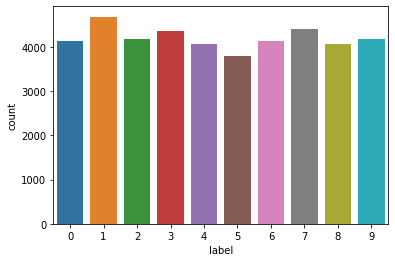

In [5]:
sns.countplot(train['label'])
train['label'].value_counts()

Convert the Numbers into Binary Vectors using One-Hot Encoding

In [6]:
orig_labels = train['label']
y = tf.keras.utils.to_categorical(orig_labels) # one-hot encoding
train.drop('label', axis=1, inplace=True)

Display a Digit from the Train Dataset

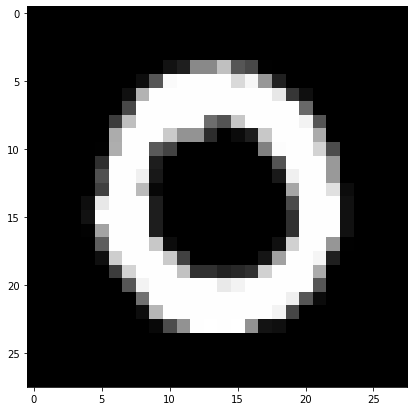

0


In [7]:
# display a number.
plt.figure(figsize=(7,7))
idx = 1

grid_data = train.iloc[idx].to_numpy().reshape(28,28)
plt.imshow(grid_data, interpolation = "none", cmap = "gray")
plt.show()

print(orig_labels[idx])

Spliting the Datatset into Train and Test Datasets

In [8]:
X_train, X_val, Y_train, Y_val = train_test_split(train, y, test_size = 0.1, random_state=2)

Reshaping the Training Dataset

In [9]:
# Reshape the Training Dataset to be an Array of Shape (training_examples_number, pixel_width, pixel_height, channel_number) 
X_train = np.array(X_train).reshape(-1, 28, 28,1)
X_val = np.array(X_val).reshape(-1, 28, 28,1)

Flattening the Datasets

In [10]:
X_train = X_train/255.0
X_val = X_val/255.0

Augmenting the Training Dataset

In [11]:
from scipy.ndimage.interpolation import shift
def shift_image(image, dx, dy,dz):
    shifted_image = shift(image, [dy, dx,dz], cval=0, mode="constant")
    return shifted_image

In [12]:
X_train_augmented = [image for image in X_train]
Y_train_augmented = [image for image in Y_train]

for dx, dy,dz in ((1,0,0), (-1,0,0), (0,1,0), (0,-1,0)):
     for image, label in zip(X_train, Y_train):
             X_train_augmented.append(shift_image(image, dx, dy,dz))
             Y_train_augmented.append(label)

In [13]:
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = np.array(X_train_augmented)[shuffle_idx]
Y_train_augmented = np.array(Y_train_augmented)[shuffle_idx]
X_train_augmented.shape

(189000, 28, 28, 1)

Traininig the CNN Model 

In [14]:
checkpoint_path = "logs/checkpoints/"

In [15]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), input_shape=(28, 28,1), activation='relu', padding="SAME"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, (3, 3), activation=tf.nn.relu, padding="SAME"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv2D(128, (3, 3), activation=tf.nn.relu, padding="SAME"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, (3, 3), activation=tf.nn.relu, padding="SAME"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation="softmax")
])

epochs=15

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                        monitor="accuracy",
                                        save_best_only=True,
                                        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(monitor="accuracy", patience=15)
]

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
history = model.fit(X_train_augmented, Y_train_augmented, epochs=epochs, callbacks=callbacks, batch_size=64)

Epoch 1/15
2954/2954 [==============================] - 499s 169ms/step - loss: 0.1429 - accuracy: 0.9560
Epoch 2/15
2954/2954 [==============================] - 493s 167ms/step - loss: 0.0533 - accuracy: 0.9843
Epoch 3/15
2954/2954 [==============================] - 494s 167ms/step - loss: 0.0414 - accuracy: 0.9876
Epoch 4/15
2954/2954 [==============================] - 493s 167ms/step - loss: 0.0349 - accuracy: 0.9896
Epoch 5/15
2954/2954 [==============================] - 492s 167ms/step - loss: 0.0293 - accuracy: 0.9914
Epoch 6/15
2954/2954 [==============================] - 492s 167ms/step - loss: 0.0262 - accuracy: 0.9920
Epoch 7/15
2954/2954 [==============================] - 492s 167ms/step - loss: 0.0228 - accuracy: 0.9930
Epoch 8/15
2954/2954 [==============================] - 493s 167ms/step - loss: 0.0214 - accuracy: 0.9933
Epoch 9/15
2954/2954 [==============================] - 493s 167ms/step - loss: 0.0189 - accuracy: 0.9941
Epoch 10/15
2954/2954 [=======================

Confusion Matrix

In [16]:
from sklearn.metrics import confusion_matrix
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
#plot_confusion_matrix(confusion_mtx, classes = range(10)) 
confusion_mtx

array([[411,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0, 485,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0, 403,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0, 416,   0,   0,   0,   0,   2,   0],
       [  0,   1,   2,   0, 456,   0,   1,   1,   0,   0],
       [  0,   0,   0,   1,   0, 369,   1,   0,   1,   0],
       [  0,   2,   0,   0,   0,   0, 410,   0,   1,   0],
       [  0,   1,   0,   0,   0,   0,   0, 445,   0,   0],
       [  0,   1,   0,   0,   0,   1,   0,   0, 379,   1],
       [  1,   0,   0,   0,   2,   0,   0,   2,   0, 404]])

Predicting a Random Digit from the Test Dataset

The label Predicted is "0"


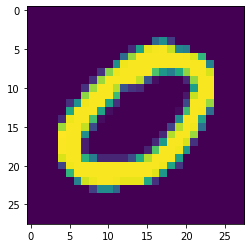

In [17]:
import random

index = random.randint(0, test.shape[0])

plt.imshow(test.iloc[index].to_numpy().reshape(28,28))

test_arr = np.array(test.iloc[index]).reshape(-1, 28, 28, 1)

test_img = test_arr/255.0

prediction = model.predict(test_img).argmax(axis=1)
print(f'The label Predicted is "{prediction[0]}"')

Submitting the Result

In [19]:
X_test = np.array(test).reshape(-1, 28, 28,1)


results = model.predict(X_test)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

In [22]:
from google.colab import files

submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("digits_cnn.csv",index=False)

files.download('digits_cnn.csv') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>